In [1]:
import torch
from torch import optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time, copy

# Trains an autoencoder for MNIST, then extracts the encoder and uses it 
# to create features for the MNIST images, and train a multiclass logistic 
# regression model on those features.
# Note that we could choose to continue fine-tuning the encoder during training.


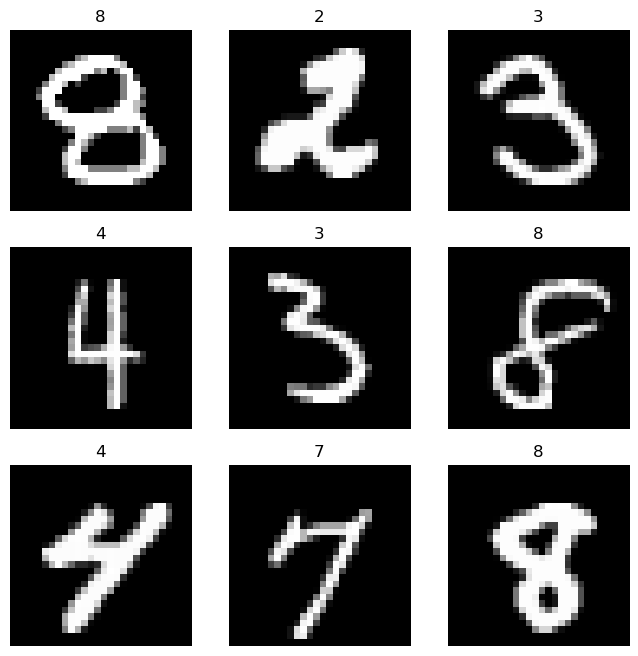

In [2]:
# Load the MNIST Datasets for test and training

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor() # converts images to be arrays of values in [0,1]
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Visualize the classes in MNIST, straight from the PyTorch Dataset and DataLoader tutorial

labels_map = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
# Define the architectures for the autoencoder and classifier

class Autoencoder(nn.Module):
   
    # in the init function we create the structure (layers) of the neural network
    def __init__(self):
        super().__init__()

        # Construct the encoder subnetwork
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9)
        )

        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Sigmoid()
            
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class MulticlassLogisticRegression(nn.Module):

    def __init__(self, encoder, d, k):
        super().__init__()
        self.encoder = encoder
        self.layer1 = nn.Linear(d, k)

    def forward(self, x):
        x = self.encoder(x)
        logits = self.layer1(x)
        return logits

In [4]:
# Train the autoencoder

# Set our hyperparameters for training
lr = 1e-3
batch_size = 64
epochs = 50

# DataLoaders will return randomly shuffled minibatches in each epoch
train_loader = DataLoader(training_data, batch_size=batch_size, 
                              shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# Before training, determine if we have access to a GPU 
# and use it if so (faster), otherwise fall back to CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

model = Autoencoder()
print(model)
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print('The number of learnable parameters in the model is', num_params)

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# set the loss function
criterion = nn.MSELoss() 


Using cpu device
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=9, out_features=18, bias=True)
    (1): ReLU()
    (2): Linear(in_features=18, out_features=36, bias=True)
    (3): ReLU()
    (4): Linear(in_features=36, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)
The number of parameters in the model is 224601


In [5]:
# Does one epoch of training. Assumes the model is in training mode

def train_epoch_autoencoder(dataloader, model, criterion, optimizer, verbose=True):
    
    size = len(dataloader.dataset)

    for batchnum, (X, _) in enumerate(dataloader):
        # Compute reconstruction loss on the minibatch
        X = torch.flatten(X, 1, -1)
        Xhat = model(X) # this calls forward on the minibatch (do not call forward directly)
        loss = criterion(Xhat, X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0 and verbose:
            # report the loss on current minibatch every 100 minibatches
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
# Computes loss and accuracy on the validation set. Assumes the model is in eval mode

def validate_autoencoder(dataloader, model, criterion, verbose=True):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad(): # we don't want to accumulate the gradients during validation
        for X, _ in dataloader:
            X = torch.flatten(X, 1, -1)
            Xhat = model(X)
            test_loss += criterion(Xhat, X).item()

    test_loss /= num_batches
    if verbose:
        print(f"Validation loss: {test_loss:>8f}")
    return test_loss

# Train the autoencoder

val_losses = np.array([0.0]*epochs)
train_losses = copy.deepcopy(val_losses)
all_time = 0 # records time spent training and evaluating model
lowest_error = np.inf
best_epoch = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    curtime = time.time()
    
    model.train() # turn model to train mode (for dropout, etc)
    train_epoch_autoencoder(train_loader, model, criterion, optimizer, verbose=True)
    
    model.eval() # turn model to evaluation mode (for dropout, etc)
    train_losses[t] = validate_autoencoder(train_loader, model, criterion, verbose=False)
    val_losses[t] = validate_autoencoder(test_loader, model, criterion, verbose=True)
    
    epoch_time = time.time() - curtime
    all_time += epoch_time

    # Store the parameters of the best performing model
    # We use the losses to determine "best" model; 
    # Note: we could also store the state_dict for the optimizer, and
    # resume optimization from the best model
    if val_losses[t] < lowest_error:
        print("This is currently the best performing model, saving it")
        lowest_error = val_losses[t]
        best_epoch = t
        torch.save(model.state_dict(), 'best_model_weights.pth')
    
    print(f"Epoch took {epoch_time:>0.1f} seconds (training + evaluation) \n")
    
print(f"Done training! Took {all_time:>0.1f} seconds")

Epoch 1
-------------------------------
loss: 0.231546  [    0/60000]
loss: 0.066571  [ 6400/60000]
loss: 0.060427  [12800/60000]
loss: 0.055160  [19200/60000]
loss: 0.053027  [25600/60000]
loss: 0.058023  [32000/60000]
loss: 0.054265  [38400/60000]
loss: 0.052316  [44800/60000]
loss: 0.051210  [51200/60000]
loss: 0.048001  [57600/60000]
Validation loss: 0.047575
This is currently the best performing model, saving it
Epoch took 8.4 seconds (training + evaluation) 

Epoch 2
-------------------------------
loss: 0.044965  [    0/60000]
loss: 0.047167  [ 6400/60000]
loss: 0.044161  [12800/60000]
loss: 0.040824  [19200/60000]
loss: 0.041221  [25600/60000]
loss: 0.037383  [32000/60000]
loss: 0.036437  [38400/60000]
loss: 0.036201  [44800/60000]
loss: 0.034725  [51200/60000]
loss: 0.035473  [57600/60000]
Validation loss: 0.035159
This is currently the best performing model, saving it
Epoch took 8.4 seconds (training + evaluation) 

Epoch 3
-------------------------------
loss: 0.032073  [   

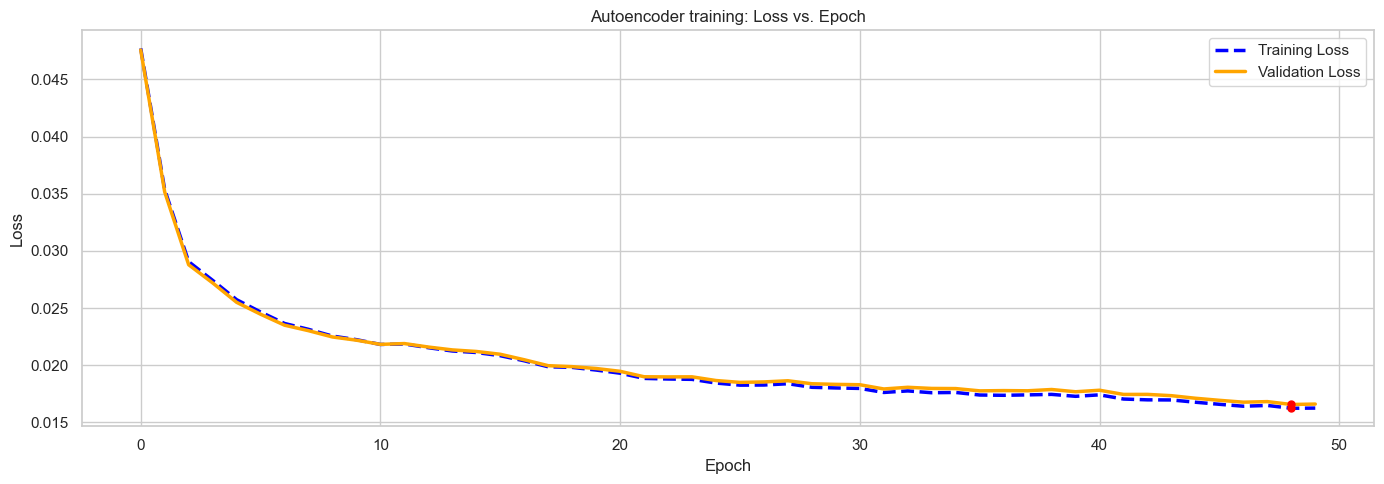

In [6]:
# Visualize convergence and generalization gap for the autoencoder

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': np.array(range(epochs)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses
})

# Set the Seaborn style
sns.set(style='whitegrid')

# Create a figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 1, figsize=(14, 5))

# Plot the losses
sns.lineplot(x='Epoch', y='Training Loss', data=data, ax=axes, label='Training Loss', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Loss', data=data, ax=axes, label='Validation Loss', 
             color='orange', linewidth=2.5, linestyle='-')
axes.set_title('Autoencoder training: Loss vs. Epoch')
axes.set_ylabel('Loss')
axes.legend()
axes.set_xlabel('Epoch')


# Add a large red dot at epoch of best model for losses 
axes.plot(best_epoch, train_losses[best_epoch], 'o', color='red', markersize=5)
axes.plot(best_epoch, val_losses[best_epoch], 'o', color='red', markersize=5)

# Draw a vertical line between training and validation losses and accuracies at epoch w/ best model
axes.vlines(x=best_epoch, ymin=train_losses[best_epoch], ymax=val_losses[best_epoch], 
               color='red', linestyle=':', linewidth=2.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [7]:
# Training code for the multiclass logistic regression model on top of the
# encoder features

# Does one epoch of training. Assumes the model is in training mode

def train_epoch(dataloader, model, criterion, optimizer, verbose=True):
    
    size = len(dataloader.dataset)

    for batchnum, (X, y) in enumerate(dataloader):
        X = torch.flatten(X, 1, -1)
        yhat = model(X) 
        loss = criterion(yhat, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batchnum % 100 == 0 and verbose:
            # report the loss on current minibatch every 100 minibatches
            loss, current = loss.item(), batchnum * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
# Computes loss and accuracy on the validation set. Assumes the model is in eval mode

def validate(dataloader, model, criterion, verbose=True):
    
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad(): # we don't want to accumulate the gradients during validation
        for X, y in dataloader:
            X = torch.flatten(X, 1, -1)
            yhat = model(X)
            test_loss += criterion(yhat, y).item()
            correct += (yhat.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if verbose:
        print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct, test_loss
    
# Create the classifier on top of the encoder features 
# freeze the parameters of the encoder
encoder = model.encoder
for param in encoder.parameters():
    param.requires_grad = False
model = MulticlassLogisticRegression(encoder, 9, 10)

print(model)
num_params = sum(param.numel() for param in model.parameters() if param.requires_grad)
print('The number of learnable parameters in the model is', num_params)

# Set our hyperparameters for training
lr = 1e-3
batch_size = 128
epochs = 8

# DataLoaders will return randomly shuffled minibatches in each epoch
train_loader = DataLoader(training_data, batch_size=batch_size, 
                              shuffle=True, num_workers=1)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=1)

# Before training, determine if we have access to a GPU 
# and use it if so (faster), otherwise fall back to CPU

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

# Choose the optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# set the loss function
criterion = nn.CrossEntropyLoss()

# Train

val_accs = np.array([0.0]*epochs)
val_losses = copy.deepcopy(val_accs)
train_accs = copy.deepcopy(val_accs)
train_losses = copy.deepcopy(val_accs)
all_time = 0 # records time spent training and evaluating model
lowest_error = np.inf
best_epoch = 0

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")

    curtime = time.time()
    
    model.train() # turn model to train mode (for dropout, etc)
    train_epoch(train_loader, model, criterion, optimizer, verbose=True)
    
    model.eval() # turn model to evaluation mode (for dropout, etc)
    train_accs[t], train_losses[t] = validate(train_loader, model, criterion, verbose=False)
    val_accs[t], val_losses[t] = validate(test_loader, model, criterion, verbose=True)
    
    epoch_time = time.time() - curtime
    all_time += epoch_time

    # Store the parameters of the best performing model
    # Note: we use the losses to determine "best" model; 
    # this is not a defininitive choice of metric, e.g. you could use accuracy
    # Note: we could also store the state_dict for the optimizer, and
    # resume optimization from the best model
    if val_losses[t] < lowest_error:
        print("This is currently the best performing model, saving it")
        lowest_error = val_losses[t]
        best_epoch = t
        torch.save(model.state_dict(), 'best_model_weights.pth')
    
    print(f"Epoch took {epoch_time:>0.1f} seconds (training + evaluation) \n")
    
print(f"Done training! Took {all_time:>0.1f} seconds")

MulticlassLogisticRegression(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=36, bias=True)
    (5): ReLU()
    (6): Linear(in_features=36, out_features=18, bias=True)
    (7): ReLU()
    (8): Linear(in_features=18, out_features=9, bias=True)
  )
  (layer1): Linear(in_features=9, out_features=10, bias=True)
)
The number of parameters in the model is 100
Using cpu device
Epoch 1
-------------------------------
loss: 4.028481  [    0/60000]
loss: 2.105989  [12800/60000]
loss: 1.484024  [25600/60000]
loss: 0.981143  [38400/60000]
loss: 0.831771  [51200/60000]
Validation Error: 
 Accuracy: 77.1%, Avg loss: 0.748378
This is currently the best performing model, saving it
Epoch took 7.6 seconds (training + evaluation) 

Epoch 2
-------------------------------
loss: 0.702785  [    0/60000]
loss: 0.766476  [12800/60000]

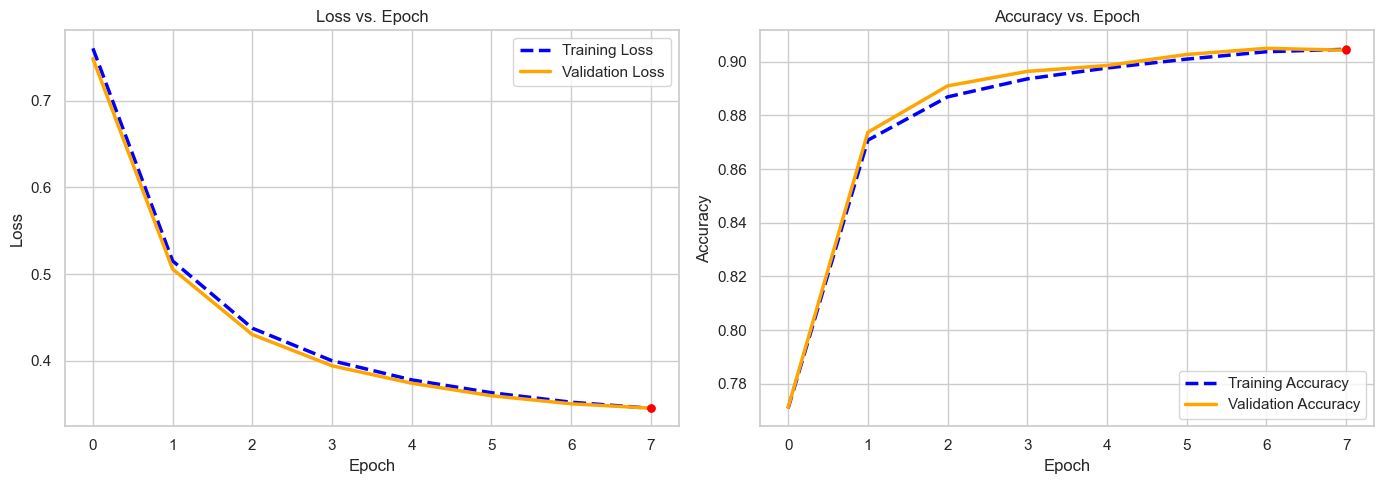

In [8]:
# Visualize convergence and generalization gap for classifier

# Create a DataFrame for easier plotting
data = pd.DataFrame({
    'Epoch': np.array(range(epochs)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Training Accuracy': train_accs,
    'Validation Accuracy': val_accs
})

# Set the Seaborn style
sns.set(style='whitegrid')

# Create a figure with subplots for loss and accuracy
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the losses
sns.lineplot(x='Epoch', y='Training Loss', data=data, ax=axes[0], label='Training Loss', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Loss', data=data, ax=axes[0], label='Validation Loss', 
             color='orange', linewidth=2.5, linestyle='-')
axes[0].set_title('Loss vs. Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_xlabel('Epoch')

# Plot the accuracies
sns.lineplot(x='Epoch', y='Training Accuracy', data=data, ax=axes[1], label='Training Accuracy', 
             color='blue', linewidth=2.5, linestyle='--')
sns.lineplot(x='Epoch', y='Validation Accuracy', data=data, ax=axes[1], label='Validation Accuracy', 
             color='orange', linewidth=2.5, linestyle='-')
axes[1].set_title('Accuracy vs. Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_xlabel('Epoch')

# Add a large red dot at epoch of best model for losses and accuracies
axes[0].plot(best_epoch, train_losses[best_epoch], 'o', color='red', markersize=5)
axes[0].plot(best_epoch, val_losses[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, train_accs[best_epoch], 'o', color='red', markersize=5)
axes[1].plot(best_epoch, val_accs[best_epoch], 'o', color='red', markersize=5)

# Draw a vertical line between training and validation losses and accuracies at epoch w/ best model
axes[0].vlines(x=best_epoch, ymin=train_losses[best_epoch], ymax=val_losses[best_epoch], 
               color='red', linestyle=':', linewidth=2.5)
axes[1].vlines(x=best_epoch, ymin=val_accs[best_epoch], ymax=train_accs[best_epoch],  
               color='red', linestyle=':', linewidth=2.5)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
